<a href="https://colab.research.google.com/github/Medianto09/Automatic-Speech-Recognition-Project-using-pretrained-model-Wav2Vec2-base-960h/blob/main/ASR_Minds_enAU_Wav2Vec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Speech Recognition Project - pretrained model Wav2Vec2-base-960h - Minds-en AU

# Mempersiapkan Environment

## Check GPU & Memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May  3 07:54:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Mempersiapkan Library

In [ ]:
!pip install --user torchaudio
!pip install librosa transformers torch
!pip install transformers datasets
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio



In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchaudio import datasets
from torchaudio import transforms
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from datasets import load_dataset
from sklearn.model_selection import train_test_split
import IPython.display as ipd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Model & Data

## Mempersiapkan Model Wav2Vec2

In [ ]:

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")




Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

## Mempersiapkan Dataset minds14 - en-AU

In [ ]:
# mengambil data hugging face Minds14 khusus English Australia
minds_14 = load_dataset("PolyAI/minds14", "en-AU")

# menampilkan struktur dataset
print(minds_14)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 654
    })
})


In [ ]:
# konversi dataset ke dataframe
df = pd.DataFrame(minds_14["train"])

In [ ]:
# cek file format
df['file_format'] = df['path'].str[-3:]

df.file_format.value_counts()

file_format
wav    654
Name: count, dtype: int64

In [ ]:
# menampilkan DataFrame
df.head(20)

,path,audio,transcription,english_transcription,intent_class,lang_id,file_format
0,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,I would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,13,2,wav
1,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hello I like to pay for Bill I would actually ...,hello I like to pay for Bill I would actually ...,13,2,wav
2,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,pay a bill,pay a bill,13,2,wav
3,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,my credit card payment is due,my credit card payment is due,13,2,wav
4,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hi I would like to make a new payment for a bill,hi I would like to make a new payment for a bill,13,2,wav
5,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hello my credit card bills due,hello my credit card bills due,13,2,wav
6,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hello I've just recently opened up an account ...,hello I've just recently opened up an account ...,13,2,wav
7,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hey there I'm just calling about making a paym...,hey there I'm just calling about making a paym...,13,2,wav
8,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,ID like to pay bills due and I don't send it o...,ID like to pay bills due and I don't send it o...,13,2,wav
9,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,ID like to pay the bill,ID like to pay the bill,13,2,wav


In [ ]:
# menampilkan data englist transcription intent_class 11
for i in df.loc[df.intent_class==11,"english_transcription"]:
  print(i)

I need to set up a joint account with my partner
yes I would like to open a joint account
hi I just want to know how do I set up a joint accounts if possible can you run through the steps in the app how to set an account up like resemble what tabs to click on the and just give me an overdue or overall step by step guide on how to do it thank you very much
I'm interested in Singapore joint account with my partner how can I go about doing that
hello my partner and I are both existing customers but we want to set up a joint account are we able to do that through the app
hi Alexa Dr John account with my partner please
I want to open a joint account
can you help me set up a joint account with my husband I don't know how to do it
how can I set up a joint account
g'day mate I'm on set up an account for me and my partner are joint account but I don't know how can you walk me through how to thanks mate
oh hi there ID like to set up a joint account with my partner and I'm not sure how to go abou

In [ ]:
for i in df.loc[df.intent_class==9,"english_transcription"]:
  print(i)

hello my car has been stolen ID like to put a hold on all transactions
I would like to stop all transactions and freeze my credit card
n I prove my card on the internet
could you please put a freeze on my card
I want to stop all future transaction from taking place freeze my card
a s good morning I just want to put a block on my ATM card at the moment please
please freeze my card
hello can you please freeze my card
hello I would like to freeze all transactions on my car as of right now is that possible I feel I've lost my car recently and I'm not entirely sure where all her might have it
stop all transactions on my card
I took all my transaction on my card
card like to freeze my card in a for transaction Bank
hi I'm just calling because ID like to freeze all transactions on my
I don't want any more transaction I like hard please
I would like to freeze my card can you please freeze my can't thanks
yes good afternoon look at like to stop all transactions on my car off reason it's been st

In [ ]:
intent_class = minds_14["train"][142]["intent_class"]  # first transcription
intent = minds_14["train"].features["intent_class"].names[intent_class]

print(intent_class,intent)

3 atm_limit


# Data Exploration

## deskripsi data dan pengecekan missing value

In [ ]:

df.to_csv('/content/drive/MyDrive/en_au.csv')

In [ ]:
# Deskripsi Data
print(df.describe())



       intent_class  lang_id
count    654.000000    654.0
mean       6.663609      2.0
std        4.017571      0.0
min        0.000000      2.0
25%        3.000000      2.0
50%        7.000000      2.0
75%       10.000000      2.0
max       13.000000      2.0


In [ ]:
# Pengecekan missing value
print(df.isnull().sum())

path                     0
audio                    0
transcription            0
english_transcription    0
intent_class             0
lang_id                  0
file_format              0
dtype: int64


 Tidak ada missing value sehingga dapat di proses lebih lanjut

## Melihat contoh data & transkirp data

In [ ]:
# menaikan / load audio file
audio_path = df.path[0]
audio, sr = librosa.load(audio_path)


In [ ]:
# audio path
audio_number_from_dataset = 0
audio_path = df.loc[audio_number_from_dataset, 'path']

# transkripsi data
audio_transcription = df.loc[audio_number_from_dataset, 'transcription']
print("the transcription:", audio_transcription)

Audio(audio_path)


the transcription: I would like to pay my electricity bill using my card can you please assist


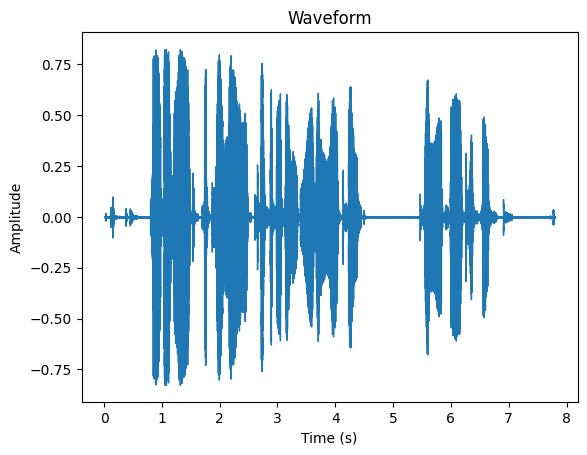

In [ ]:
# Plot the waveform
plt.figure()
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

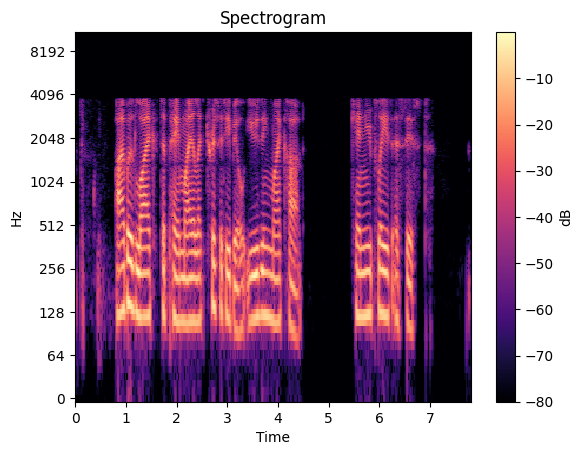

In [ ]:
# Load audio file
audio_path = df.path[0]
audio, sr = librosa.load(audio_path)

# Compute the spectrogram using STFT
D = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.title('Spectrogram')
plt.colorbar(label='dB')
plt.show()

In [ ]:
intent_class_interpret = list()
for idx in df.index:
  intent_class = minds_14["train"][idx]["intent_class"]
  interpret = minds_14['train'].features['intent_class'].names[intent_class]
  intent_class_interpret.append(interpret)

df['intent_class_interpret'] = intent_class_interpret

In [ ]:
# Function to calculate duration of audio files
def calculate_duration(audio_path):
    audio, sr = librosa.load(audio_path)
    duration = len(audio) / sr
    return duration

# Apply the function to calculate duration for each audio file path in the DataFrame
df['duration'] = df['path'].apply(calculate_duration)

In [ ]:
# Group the DataFrame by class and calculate the average duration per class
avg_duration_per_class = df.groupby('intent_class_interpret')['duration'].mean()

# Display the results
print(avg_duration_per_class)

intent_class_interpret
abroad                 11.504571
address                 7.697310
app_error               9.713021
atm_limit               9.686008
balance                 6.498502
business_loan           7.586292
card_issues             8.326189
cash_deposit            7.724855
direct_debit            8.014102
freeze                  7.371338
high_value_payment     11.964272
joint_account           7.591903
latest_transactions     8.559381
pay_bill                6.546775
Name: duration, dtype: float64


# Inferencing

## Tokenize dengan dengan model pretrained Wav2Vec2-base-960h

In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [ ]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mod

In [ ]:
wav2vec_predicted = list()
wav2vec_inference_time = list()

In [ ]:
import time

for idx in df.index:
  # Load audio file
  audio_path = df.path[idx]
  start_time = time.time()  # Use time.time() for current time

  input_audio, sr = librosa.load(audio_path, sr=16000)

  input_values = tokenizer(input_audio, return_tensors='pt').input_values
  logits = model(input_values).logits
  predicted_ids = torch.argmax(logits, dim=-1)

  text = tokenizer.batch_decode(predicted_ids)[0]

  end_time = time.time()
  inference_time = end_time - start_time

  wav2vec_predicted.append(text)
  wav2vec_inference_time.append(inference_time)

## menampilkan hasil predicted dan inference

In [ ]:
df.shape

(654, 6)

In [ ]:
df['wav2vec_predicted'] = wav2vec_predicted
df['wav2vec_inference_time'] = wav2vec_inference_time
df.head()

,path,audio,transcription,english_transcription,intent_class,lang_id,wav2vec_inference_time,wav2vec_predicted
0,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,i would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,13,2,0.684869,I WOULD LIKE TO PAY MY ELECTRICITY BILL USING ...
1,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hello i like to pay for bill i would actually ...,hello I like to pay for Bill I would actually ...,13,2,0.780234,ELL I LIKE TO PAY FOR BILL IM I OUGHT I SHALL ...
2,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,pay a bill,pay a bill,13,2,0.360111,I A MILL
3,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,my credit card payment is due,my credit card payment is due,13,2,0.273007,MY CREDIT GOD PAYMENT IS JUNE
4,/root/.cache/huggingface/datasets/downloads/ex...,{'path': '/root/.cache/huggingface/datasets/do...,hi i would like to make a new payment for a bill,hi I would like to make a new payment for a bill,13,2,0.379257,WHY I'D LIKE TO MAKE A YE PAYMENT FOR A BILL


In [ ]:
df.to_csv('base_model_inferencing.csv', index=False)

In [ ]:
# melihat perfroma averange inference time
if 'wav2vec_inference_time' not in df.columns:
    df['wav2vec_inference_time'] = pd.Series(dtype=float)

# Menghitung average inference time
average_inference_time = df['wav2vec_inference_time'].mean()

# Print
print(f"Average inference time: {average_inference_time:.4f} seconds")

Average inference time: 0.8517 seconds


# Mengecek Performa

In [ ]:
import editdistance

def calculate_wer(predicted_text, reference_text):
    distance = editdistance.eval(predicted_text.split(), reference_text.split())
    wer = distance / len(reference_text.split())
    return wer

def calculate_cer(predicted_text, reference_text):
    distance = editdistance.eval(predicted_text, reference_text)
    cer = distance / len(reference_text)
    return cer

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

def calculate_bleu_score(predicted_text, reference_text):
    predicted_tokens = word_tokenize(predicted_text)
    reference_tokens = word_tokenize(reference_text)
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens)
    return bleu_score

In [ ]:
data_metrics = df[['wav2vec_predicted', 'transcription', 'wav2vec_inference_time']]

## WER Score

In [ ]:
data_metrics['wer'] = data_metrics.apply(lambda row: calculate_wer(row['wav2vec_predicted'], row['transcription']), axis=1)
print("WER:")
print(np.mean(data_metrics['wer']))

WER:
0.426582592290448


<ipython-input-23-ad75cebb6949>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metrics['wer'] = data_metrics.apply(lambda row: calculate_wer(row['wav2vec_predicted'], row['transcription']), axis=1)


## CER Score

In [ ]:
data_metrics['cer'] = data_metrics.apply(lambda row: calculate_cer(row['wav2vec_predicted'], row['transcription']), axis=1)
print("\nCER:")
print(np.mean(data_metrics['cer']))


CER:
0.22986828922923327


<ipython-input-24-904c9f932de9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metrics['cer'] = data_metrics.apply(lambda row: calculate_cer(row['wav2vec_predicted'], row['transcription']), axis=1)


## BLEU Score

In [ ]:
  import nltk
  nltk.download('punkt')


data_metrics['bleu_score'] = data_metrics.apply(lambda row: calculate_bleu_score(row['wav2vec_predicted'], row['transcription']), axis=1)
print("\nBLEU Score:")
print(np.mean(data_metrics['bleu_score']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram over


BLEU Score:
0.41735648179960744
